Udwadia-Kalaba formulation:

$\textbf{M}\ddot{\vec{q}} = \vec{Q} + \vec{Q}_c$

$
\begin{cases}
\frac{d^2}{dt^2}\big(f(\vec{q}, t) = 0\big)\quad holonomic \\
\frac{d}{dt}\big(A(\vec{q}, t)\dot{\vec{q}} + c(\vec{q}, t) = 0\big) \quad nonholonomic
\end{cases}
\rightarrow \quad
\textbf{A}(\vec{q}, t) \ddot{\vec{q}} 
= \vec{b}(\vec{q}, \vec{\dot{q}}, t)$

$\vec{Q}_c = \textbf{M}^{1/2}(\textbf{AM}^{-1/2})^+ (\vec{b} - \textbf{AM}^{-1}\vec{Q})$


$\color{yellowgreen}\boxed{
    \ddot{\vec{q}}_{constr} = \textbf{M}^{-1}\vec{Q} + \textbf{M}^{-1/2}(\textbf{AM}^{-1/2})^+ (\vec{b} - \textbf{AM}^{-1}\vec{Q})
}$


Mathematical Pendulum:

$
\underbrace{\begin{bmatrix}m & 0 \\ 0 & m \end{bmatrix}}_{\textbf{M}} 
\underbrace{\begin{bmatrix}\ddot{x} \\ \ddot{y} \end{bmatrix}}_{\ddot{\vec{q}}}
= \vec{Q} + \vec{Q}_c
$

$
f(\vec{q}): x^2 + y^2 = L^2
$

$
\frac{d^2}{dt^2} f(\vec{q}): 2(x\ddot{x} + y\ddot{y} + \dot{x}^2 + \dot{y}^2) = 0
$

$
\textbf{A} = [2x \quad 2y]^T, \quad \vec{b} = [-2\dot{x}^2 - 2\dot{y}^2]
$

$
\vec{Q} = [0 \quad -mg]^T
$



In [12]:
import sympy 
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import ReferenceFrame
from sympy.abc import t
from scipy.integrate import odeint
import numpy as np
from sympy.utilities.lambdify import lambdify
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [13]:
I = ReferenceFrame("I")

m, g = sympy.symbols("m g")
M = sympy.Matrix([[m, 0], 
                  [0, m]]) 

L = sympy.symbols("L") 
x_pos, y_pos = dynamicsymbols("x y", real=True) 

r = x_pos*I.x + y_pos*I.y 

length_constraint = sympy.Eq(r.dot(r) - L**2, 0)

A, b = sympy.linear_eq_to_matrix(
    [length_constraint.lhs.diff(t, 2)], 
    [x_pos.diff(t, 2), y_pos.diff(t, 2)])

In [14]:
Q = sympy.Matrix([0, -m*g])

M_inv = M.pinv()
M_sqrt_inv = sympy.sqrt(M_inv)

In [15]:
ddot_q_u = M_inv @ Q

ddot_q_c = M_sqrt_inv @ ((A*M_sqrt_inv).pinv()) @ (b - A @ M_inv @ Q)
ddot_q_c = sympy.Matrix([
    ddot_q_c[0].simplify(),
    ddot_q_c[1].simplify()
])

ddot_q = ddot_q_u + ddot_q_c

vx, vy  = sympy.symbols("v_x v_y")
x, y = sympy.symbols("x y")

subs_to_cauchy = {
    x_pos: x, y_pos: y,
    x_pos.diff(t): vx, y_pos.diff(t): vy 
}

class Model:
    def __init__(self, ddot_eq_list):
        self.ddot_eq_list = ddot_eq_list

    def model(self, q, t, params):
        m, g = params["m"], params["g"]
        x, y, vx, vy = q
        dx_dt = vx
        dy_dt = vy
        dvx_dt = self.ddot_eq_list[0](x, y, vx, vy, m, g)
        dvy_dt = self.ddot_eq_list[1](x, y, vx, vy, m, g)

        return [dx_dt, dy_dt, dvx_dt, dvy_dt]

symbolic_args = [x, y, vx, vy, m, g]
ddot_x_expr = lambdify(symbolic_args, ddot_q[0].subs(subs_to_cauchy), 'numpy')
ddot_y_expr = lambdify(symbolic_args, ddot_q[1].subs(subs_to_cauchy), 'numpy')

pendulum = Model([ddot_x_expr, ddot_y_expr])

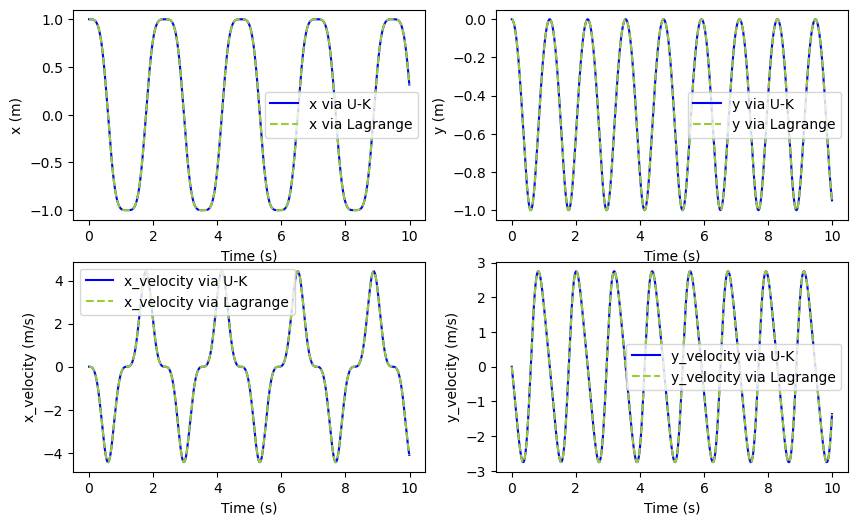

In [16]:
def lagrange_pendulum(state, t, params):
    g, L = params["g"], params["L"] 
    theta, omega = state
    dtheta_dt, domega_dt = omega, -(g/L) * np.sin(theta)

    return [dtheta_dt, domega_dt]

time = np.arange(0, 10, 0.01)
x0, y0 = 1, 0

params = { "m": 3, "g": 9.81, "L": np.sqrt(x0**2 + y0**2) }

sol_udwadia = odeint(pendulum.model, [x0, y0, 0, 0], time, args=(params,))
x_udwadia = sol_udwadia[:, 0]
y_udwadia = sol_udwadia[:, 1]
vx_udwadia = sol_udwadia[:, 2]
vy_udwadia = sol_udwadia[:, 3]

sol_lagrange = odeint(lagrange_pendulum, [np.pi/2, 0], time, args=(params,))
theta = sol_lagrange[:, 0]
omega = sol_lagrange[:, 1]
x_lagrange = params["L"]*np.sin(theta)
y_lagrange = -params["L"]*np.cos(theta)
vx_lagrange = params["L"]*omega*np.cos(theta)
vy_lagrange = params["L"]*omega*np.sin(theta)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

labels = ["x", "y", "x_velocity", "y_velocity"]
units = ["m", "m", "m/s", "m/s"]
variables = [[x_udwadia, x_lagrange], [y_udwadia, y_lagrange], 
             [vx_udwadia, vx_lagrange], [vy_udwadia, vy_lagrange]]

for row in range(2):
    for col in range(2):
        i = 2*row + col
        y1, y2 = variables[i]
        axes[row][col].plot(time, y1, 
                     label=f'{labels[i]} via U-K', 
                     color='blue')
        axes[row][col].plot(time, y2, 
                     label=f'{labels[i]} via Lagrange', 
                     color='yellowgreen', 
                     linestyle='dashed')
        axes[row][col].set_xlabel(f"Time (s)")
        axes[row][col].set_ylabel(f"{labels[i]} ({units[i]})")

        axes[row][col].legend()